In [1]:
import datasets
import umap as umap

data = datasets.load_dataset("/home/byrdofafeather/ByrdOfAFeather/TEMPSCRATCH", data_files={"train": "final.csv"})
print(data)

Using custom data configuration TEMPSCRATCH-8288c2084349c91c
Reusing dataset csv (/home/byrdofafeather/.cache/huggingface/datasets/csv/TEMPSCRATCH-8288c2084349c91c/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', '0', '1'],
        num_rows: 5249
    })
})


In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import pandas as pd
import json
import tqdm

embeds = []
labels = {'0': [], '1': []}
batch_size = 8
for idx in tqdm.tqdm(range(0, len(data['train']['0']), batch_size)):
	tokenized = tokenizer(data['train']['0'][idx: idx+batch_size], return_tensors="pt", truncation=True, padding=True)
	for key, value in tokenized.items():
		tokenized[key] = value.cuda()
	embeds.append(pd.DataFrame(model(**tokenized)[0][:, 0, :].detach().cpu().flatten().numpy().reshape(768, len(data["train"]["0"][idx:idx+batch_size])), index=list(range(768)), columns=[idx + n for n in range(len(data["train"]["0"][idx:idx+batch_size]))]).transpose())
	for sub_idx in range(0, len(data["train"]["0"][idx:idx+batch_size])):
		labels[str(data['train']['1'][idx+sub_idx])].append(idx+sub_idx)

embeds = pd.concat(embeds)
embeds.to_csv("all.csv")
with open(f"all_indicies.json", 'w') as f:
	json.dump(labels, f)


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


(5249, 769)
here


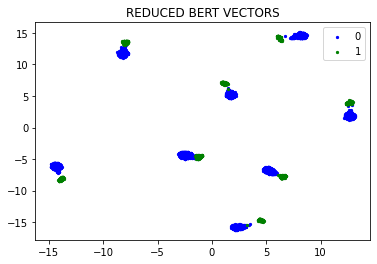

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import umap
import json

all_vectors = pd.read_csv("all.csv")
print(all_vectors.shape)
print("here")
mapper = umap.UMAP(random_state=225530)
umap_reduced = mapper.fit_transform(all_vectors.values[:, 1:])

def plot_by_class(vectors=umap_reduced, only_use="", index_mapping={}):
	with open("all_indicies.json", 'r') as f:
		bert_vectors = json.load(f)
	colors = ['b', 'g', 'r', 'purple']
	color_idx = 0
	for key, value in bert_vectors.items():
		if only_use:
			if only_use not in key: continue
		if index_mapping:
			plt.scatter(vectors[[index_mapping[i] for i in value], 0], vectors[[index_mapping[i] for i in value], 1], color=colors[color_idx], label=key, s=5)
		else:
			plt.scatter(vectors[value, 0], vectors[value, 1], color=colors[color_idx], label=key, s=5)
		color_idx += 1
	plt.legend()
	plt.show()


plt.title("REDUCED BERT VECTORS")
plot_by_class()